In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Conv2D,Flatten,MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau
from tensorflow.keras.layers import BatchNormalization

#Đường dẫn thư mục train và test
train_path = r'.\train'
test_path = r'.\test'
val_path = r'.\val'

batch_size = 16 

img_height = 500
img_width = 500

In [2]:
image_gen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
)

test_data_gen = ImageDataGenerator(rescale=1./255)

In [3]:
train_generator = image_gen.flow_from_directory(
    train_path,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    color_mode='grayscale'
)

test = test_data_gen.flow_from_directory(
    test_path,
    target_size=(img_height, img_width),
    color_mode='grayscale', 
    shuffle=False,
    class_mode='binary',
    batch_size=batch_size
)

validation_generator = image_gen.flow_from_directory(
    val_path,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    color_mode='grayscale'
)

Found 1943 images belonging to 2 classes.
Found 611 images belonging to 2 classes.
Found 497 images belonging to 2 classes.


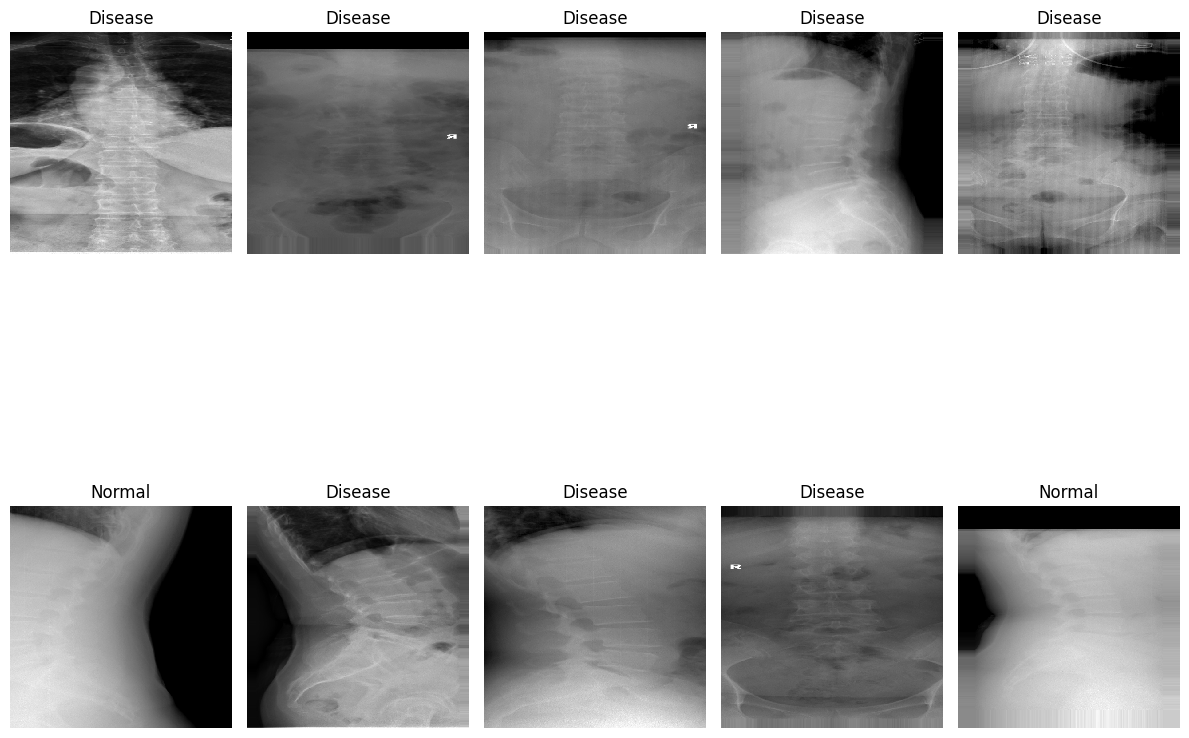

In [4]:
plt.figure(figsize=(12, 12))
for i in range(0, 10):
    plt.subplot(2, 5, i+1)
    for X_batch, Y_batch in train_generator:
        image = X_batch[0]        
        dic = {0:'Normal', 1:'Disease'}
        plt.title(dic.get(Y_batch[0]))
        plt.axis('off')
        plt.imshow(np.squeeze(image),cmap='gray',interpolation='nearest')
        break
plt.tight_layout()
plt.show()

In [5]:
cnn = Sequential()
cnn.add(Conv2D(32, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
cnn.add(BatchNormalization()) 
cnn.add(MaxPooling2D(pool_size = (2, 2)))
cnn.add(Conv2D(64, (3, 3), activation="relu"))
cnn.add(BatchNormalization()) 
cnn.add(MaxPooling2D(pool_size = (2, 2)))
cnn.add(Flatten())
cnn.add(Dense(128, activation = 'relu'))
cnn.add(Dense(64, activation = 'relu'))
cnn.add(Dense(1, activation = 'sigmoid'))
cnn.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])


In [6]:
cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 498, 498, 32)      320       
                                                                 
 batch_normalization (Batch  (None, 498, 498, 32)      128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 249, 249, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 247, 247, 64)      18496     
                                                                 
 batch_normalization_1 (Bat  (None, 247, 247, 64)      256       
 chNormalization)                                                
                                                        

In [7]:
from tensorflow.keras.utils import plot_model
plot_model(cnn,show_shapes=True, show_layer_names=True, rankdir='TB', expand_nested=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [8]:
early = EarlyStopping(monitor="val_loss", mode="min", patience=3)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)
callbacks_list = [ early, learning_rate_reduction]

In [9]:
from sklearn.utils.class_weight import compute_sample_weight

unique_classes = np.unique(train_generator.classes)
weights = compute_sample_weight(class_weight='balanced', y=train_generator.classes)

# Tạo dictionary để ánh xạ từ lớp sang trọng số tương ứng
cw = dict(zip(unique_classes, weights))

print(cw)

{0: 1.763157894736842, 1: 1.763157894736842}


In [10]:
cnn.fit(train_generator,epochs=25, validation_data=validation_generator, class_weight=cw, callbacks=callbacks_list)

Epoch 1/25
122/122 [==============================] - 273s 2s/step - loss: 114.8094 - accuracy: 0.5841 - val_loss: 24.5598 - val_accuracy: 0.6901 - lr: 0.0010
Epoch 2/25
122/122 [==============================] - 281s 2s/step - loss: 68.2070 - accuracy: 0.5996 - val_loss: 106.3510 - val_accuracy: 0.2897 - lr: 0.0010
Epoch 3/25
122/122 [==============================] - 284s 2s/step - loss: 46.6296 - accuracy: 0.6037 - val_loss: 23.5885 - val_accuracy: 0.6942 - lr: 0.0010
Epoch 4/25
122/122 [==============================] - 328s 3s/step - loss: 26.5340 - accuracy: 0.6145 - val_loss: 10.7088 - val_accuracy: 0.6720 - lr: 0.0010
Epoch 5/25
122/122 [==============================] - 514s 4s/step - loss: 17.5210 - accuracy: 0.6109 - val_loss: 12.9084 - val_accuracy: 0.6982 - lr: 0.0010
Epoch 6/25
122/122 [==============================] - 423s 3s/step - loss: 8.9238 - accuracy: 0.6109 - val_loss: 6.3161 - val_accuracy: 0.6821 - lr: 0.0010
Epoch 7/25
122/122 [==============================] 

In [11]:
cnn.save('sequential_model.h5')

c:\Users\admin\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [12]:
from sklearn.metrics import confusion_matrix, classification_report

# Evaluate the model on the test data
test_accu = cnn.evaluate(test)
print('The testing accuracy is:', test_accu[1] * 100, '%')

# Predict the labels for the test data
y_pred = cnn.predict(test)
y_pred = np.round(y_pred).astype(int)  # Chuyển đổi dự đoán thành nhãn nhị phân (0 hoặc 1)

# Get the true labels
y_true = test.classes

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
print('Confusion Matrix:')
print(conf_matrix)

# Compute classification report
class_report = classification_report(y_true, y_pred, target_names=['Normal', 'Disease'])
print('Classification Report:')
print(class_report)

# Extract Sensitivity, Specificity, and F1-Score from confusion matrix
tn, fp, fn, tp = conf_matrix.ravel()
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)
precision = tp / (tp + fp)
recall = sensitivity  # Recall là tên khác của Sensitivity
f1_score = 2 * (precision * recall) / (precision + recall)

print(f'Sensitivity: {sensitivity * 100:.2f}%')
print(f'Specificity: {specificity * 100:.2f}%')
print(f'F1-Score: {f1_score:.2f}')

39/39 [==============================] - 16s 404ms/step - loss: 0.7913 - accuracy: 0.6809
The testing accuracy is: 68.08510422706604 %
39/39 [==============================] - 13s 312ms/step
Confusion Matrix:
[[ 18 179]
 [ 16 398]]
Classification Report:
              precision    recall  f1-score   support

      Normal       0.53      0.09      0.16       197
     Disease       0.69      0.96      0.80       414

    accuracy                           0.68       611
   macro avg       0.61      0.53      0.48       611
weighted avg       0.64      0.68      0.59       611

Sensitivity: 96.14%
Specificity: 9.14%
F1-Score: 0.80
